
# AAE 722 — Lab 7: Nonlinear Regression & GAMs  
**Name:** Gary Sun 


In [1]:

# Common imports
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm

from ISLP import load_data

# Robust helpers for splines/natural splines across ISLP versions
use_islp_models_ns = True
use_islp_models_bs = True
try:
    from ISLP.models import ns
except Exception:
    use_islp_models_ns = False
try:
    from ISLP.models import BSpline
except Exception:
    use_islp_models_bs = False

# Patsy fallbacks (bs= B-spline, cr = natural spline)
from patsy import dmatrix

# Robust pygam imports
try:
    from pygam import LinearGAM, s
    have_pygam = True
except Exception:
    have_pygam = False

# ISLP plotting helper for pygam (optional)
try:
    from ISLP.pygam import plot_gam as islp_plot_gam
    have_islp_plot_gam = True
except Exception:
    have_islp_plot_gam = False

RNG = np.random.default_rng(722)  # fixed seed
print("Environment OK:", use_islp_models_ns, use_islp_models_bs, have_pygam)


Environment OK: True False True



## Q1. Polynomial Regression — Auto (mpg ~ horsepower)

Fit polynomial regression models of degrees 1–5 using `horsepower` to predict `mpg`.  
Use `anova_lm()` to compare nested models and report which degree is justified.  
Also report the F-statistic and p-value for **degree 3 vs degree 4**.


In [2]:

# Q1 — Code
Auto = load_data('Auto').dropna()

y = Auto['mpg'].to_numpy()
hp = Auto['horsepower'].to_numpy()

models = {}
for deg in range(1, 6):
    X_poly = np.vander(hp, N=deg+1, increasing=True)  # [1, x, x^2, ...]
    models[deg] = sm.OLS(y, X_poly).fit()

rows = []
for k in range(1, 5):
    res = anova_lm(models[k], models[k+1])
    last = res.iloc[-1]
    rows.append({
        "comparison": f"deg {k} -> deg {k+1}",
        "df_diff": float(last['df_diff']),
        "ss_diff": float(last['ss_diff']),
        "F": float(last['F']),
        "Pr(>F)": float(last['Pr(>F)'])
    })
anova_df = pd.DataFrame(rows)
display(anova_df)

justified_degree = 1
for r in rows:
    if r["Pr(>F)"] < 0.05:
        justified_degree = int(r["comparison"].split()[-1])
    else:
        break
print(f"Suggested degree by sequential ANOVA @ alpha=0.05: degree {justified_degree}")

res_3v4 = anova_lm(models[3], models[4])
F_3v4 = float(res_3v4.iloc[-1]['F'])
p_3v4 = float(res_3v4.iloc[-1]['Pr(>F)'])
print(f"F-statistic (deg 3 vs deg 4): {F_3v4:.4f}, p-value: {p_3v4:.4g}")


,comparison,df_diff,ss_diff,F,Pr(>F)
0,deg 1 -> deg 2,1.0,1943.886460,101.608283,2.196340e-21
1,deg 2 -> deg 3,1.0,15.593405,0.814690,3.672973e-01
2,deg 3 -> deg 4,1.0,26.913375,1.407588,2.361851e-01
3,deg 4 -> deg 5,1.0,176.150944,9.413092,2.306429e-03


Suggested degree by sequential ANOVA @ alpha=0.05: degree 2
F-statistic (deg 3 vs deg 4): 1.4076, p-value: 0.2362



## Q2. Regression Splines with B-Splines — Boston (medv ~ lstat)

Fit an OLS model using a B-spline basis for `lstat` with internal knots `[10, 20, 30]` and `intercept=True`.  
Report model **R-squared** and the **number of basis columns**.


In [3]:

# Q2 — Code
Boston = load_data('Boston').dropna()
x = Boston['lstat'].to_numpy()
y = Boston['medv'].to_numpy()

if use_islp_models_bs:
    from ISLP.models import BSpline
    bs_term = BSpline('lstat', internal_knots=[10, 20, 30], intercept=True)
    X_bs = bs_term.transform(Boston)  # ndarray
    X_design = X_bs
    basis_cols = X_design.shape[1]
else:
    X_design = dmatrix("1 + bs(lstat, knots=(10,20,30), degree=3, include_intercept=True)",
                       Boston, return_type="dataframe")
    basis_cols = X_design.shape[1]

model_bs = sm.OLS(y, np.asarray(X_design)).fit()
print("Q2 R-squared:", model_bs.rsquared)
print("Number of B-spline basis columns:", basis_cols)


Q2 R-squared: 0.6834878749017886
Number of B-spline basis columns: 8



## Q3. Natural Splines — Hitters (Salary ~ Years)

Use a natural spline with **df = 4** for `Years` (via `ns()` from ISLP; Patsy `cr()` fallback).  
Fit OLS, report **R-squared**, and overlay the fitted curve on the scatter plot.


Q3 R-squared: 0.2712862486154737
Shapes — X_ns: (263, 5) , X_design: (263, 5)


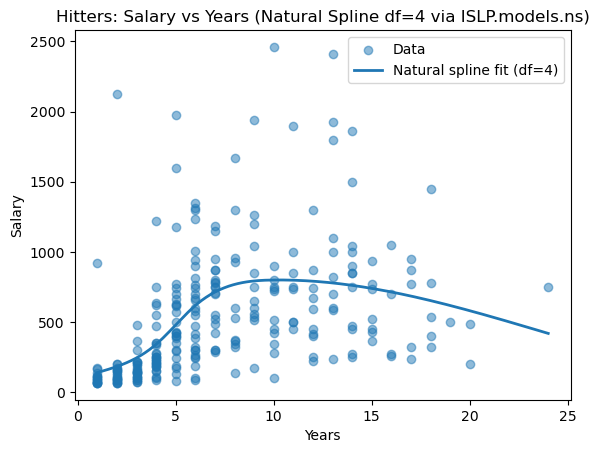

In [13]:
# Q3 — Natural Spline using ISLP.models.ns() (robust across ISLP versions)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from ISLP import load_data
from ISLP.models import ns
# Try to use ModelSpec when available
try:
    from ISLP.models import ModelSpec as MS
    have_MS = True
except Exception:
    have_MS = False

# 1) Load & clean
Hitters = load_data('Hitters').dropna()
x = Hitters['Years'].to_numpy()
y = Hitters['Salary'].to_numpy()

# 2) Build natural spline basis via ns() from ISLP.models
ns_term = ns('Years', df=4)

# --- Path A: ModelSpec pipeline (preferred when available) ---
X_ns = None
if have_MS:
    try:
        design = MS([ns_term]).fit(Hitters)      # fit the spec on the DF
        X_ns = design.transform(Hitters)         # (n_samples, 4)
    except Exception:
        X_ns = None

# --- Path B: Some ISLP versions allow calling the Feature on a DataFrame ---
if X_ns is None:
    try:
        X_ns = ns_term(Hitters)                  # (n_samples, 4) if supported
    except Exception:
        X_ns = None

# --- Path C: As a last resort, evaluate ns on the numeric vector and stack ---
if X_ns is None:
    # ns(x, df=4) may return a list/tuple of column vectors → column_stack into (n, df)
    X_ns_list = ns(Hitters['Years'].to_numpy(), df=4)
    X_ns = np.column_stack(X_ns_list)

# 3) Add intercept & fit OLS
X_design = sm.add_constant(X_ns)
model_ns = sm.OLS(y, X_design).fit()
print("Q3 R-squared:", model_ns.rsquared)
print("Shapes — X_ns:", X_ns.shape, ", X_design:", X_design.shape)

# 4) Plot fitted curve on a grid
x_grid = np.linspace(x.min(), x.max(), 200)
grid_df = pd.DataFrame({'Years': x_grid})

# build grid design with the same ns_term via the same route
Xg_ns = None
if have_MS:
    try:
        Xg_ns = design.transform(grid_df)
    except Exception:
        Xg_ns = None
if Xg_ns is None:
    try:
        Xg_ns = ns_term(grid_df)
    except Exception:
        Xg_ns = None
if Xg_ns is None:
    Xg_ns_list = ns(x_grid, df=4)
    Xg_ns = np.column_stack(Xg_ns_list)

Xg = sm.add_constant(Xg_ns)
y_hat = model_ns.predict(Xg)

plt.figure()
plt.scatter(x, y, alpha=0.5, label='Data')
plt.plot(x_grid, y_hat, lw=2, label='Natural spline fit (df=4)')
plt.xlabel('Years'); plt.ylabel('Salary')
plt.title('Hitters: Salary vs Years (Natural Spline df=4 via ISLP.models.ns)')
plt.legend(); plt.show()



## Q4. GAM — College (Outstate ~ s(Room.Board) + s(PhD))

Fit a GAM using `LinearGAM` with smoothing splines for `Room.Board` and `PhD` (default lambda).  
Create partial dependence plots for both predictors and report training **R-squared** via `.score()`.


Q4 GAM training R-squared: 0.5142227904413001


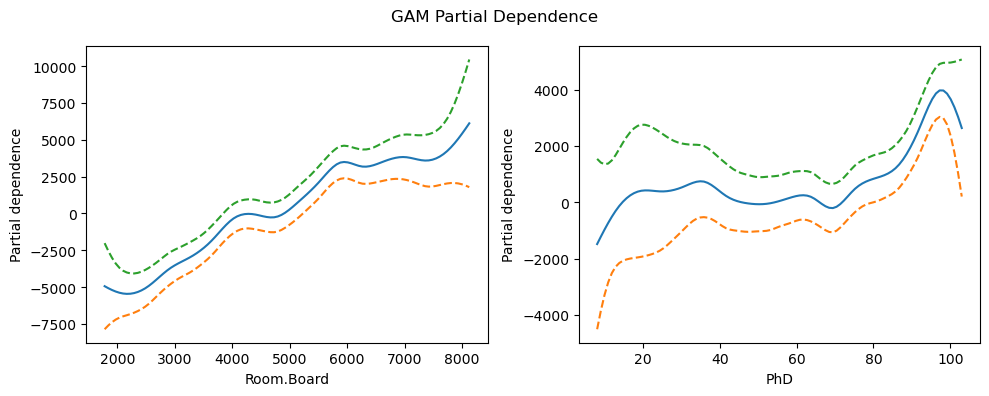

In [14]:

# Q4 — Code
College = load_data('College').dropna()

if have_pygam:
    from pygam import LinearGAM, s
    X = College[['Room.Board','PhD']].to_numpy()
    y = College['Outstate'].to_numpy()

    gam = LinearGAM(s(0) + s(1)).fit(X, y)
    print("Q4 GAM training R-squared:", gam.score(X, y))

    # Partial dependence plots
    if have_islp_plot_gam:
        fig, axes = islp_plot_gam(gam, X=X, feature_names=['Room.Board','PhD'])
    else:
        fig, axes = plt.subplots(1, 2, figsize=(10,4))
        for j, ax in enumerate(axes):
            XX = gam.generate_X_grid(term=j)
            ax.plot(XX[:, j], gam.partial_dependence(term=j, X=XX))
            pd_low, pd_high = gam.partial_dependence(term=j, X=XX, width=0.95)
            ax.plot(XX[:, j], pd_high, ls='--')
            ax.set_xlabel(['Room.Board','PhD'][j])
            ax.set_ylabel('Partial dependence')
        plt.suptitle('GAM Partial Dependence'); plt.tight_layout(); plt.show()
else:
    print("pygam not installed. Please `pip install pygam` to run Q4.")



## Q5. Step Functions — Carseats (Sales ~ Price bins)

Bin `Price` into **4** equal-width bins with `pd.cut(bins=4)`.  
Create indicator variables (drop the first as baseline) and fit OLS.  
Report **coefficients** of bin dummies, **R-squared**, and identify the bin with the strongest negative effect.


In [17]:
# Q5 — Step Functions (robust numeric types for OLS)

Carseats = load_data('Carseats').dropna()

price_bins = pd.cut(Carseats['Price'], bins=4)

dummies = pd.get_dummies(price_bins, drop_first=True).astype(float)

X = sm.add_constant(dummies)                 # DataFrame OK
y = Carseats['Sales'].astype(float).values   

model_step = sm.OLS(y, X).fit()

print(model_step.summary())

coef_bins = model_step.params.drop('const')
r2_step = model_step.rsquared

print("\nQ5 R-squared:", r2_step)
print("\nBin indicator coefficients:")
print(coef_bins)

strongest_neg_bin = coef_bins.idxmin()
print(f"\nStrongest negative effect on Sales: bin '{strongest_neg_bin}'")


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     22.90
Date:                Sun, 19 Oct 2025   Prob (F-statistic):           1.09e-13
Time:                        14:13:17   Log-Likelihood:                -950.36
No. Observations:                 400   AIC:                             1909.
Df Residuals:                     396   BIC:                             1925.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              10.9600      0.989     